# The Three Ways of Attention and Dot Product Attention: Ungraded Lab Notebook

In this notebook you'll explore the three ways of attention (encoder-decoder attention, causal attention, and bi-directional self attention) and how to implement the latter two with dot product attention. 

## Background

As you learned last week, **attention models** constitute powerful tools in the NLP practitioner's toolkit. Like LSTMs, they learn which words are most important to phrases, sentences, paragraphs, and so on. Moreover, they mitigate the vanishing gradient problem even better than LSTMs. You've already seen how to combine attention with LSTMs to build **encoder-decoder models** for applications such as machine translation. 

#< src="images/C4_W2_L3_dot-product-attention_S01_introducing-attention_stripped.png" width="500"/>
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>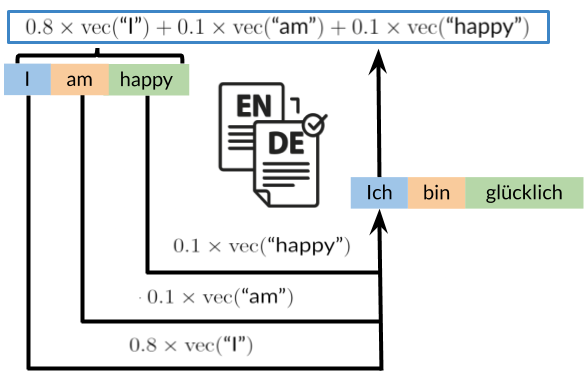</body></html>

This week, you'll see how to integrate attention into **transformers**. Because transformers are not sequence models, they are much easier to parallelize and accelerate. Beyond machine translation, applications of transformers include: 
* Auto-completion
* Named Entity Recognition
* Chatbots
* Question-Answering
* And more!

Along with embedding, positional encoding, dense layers, and residual connections, attention is a crucial component of transformers. At the heart of any attention scheme used in a transformer is **dot product attention**, of which the figures below display a simplified picture:

< src="images/C4_W2_L3_dot-product-attention_S03_concept-of-attention_stripped.png" width="500"/>
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>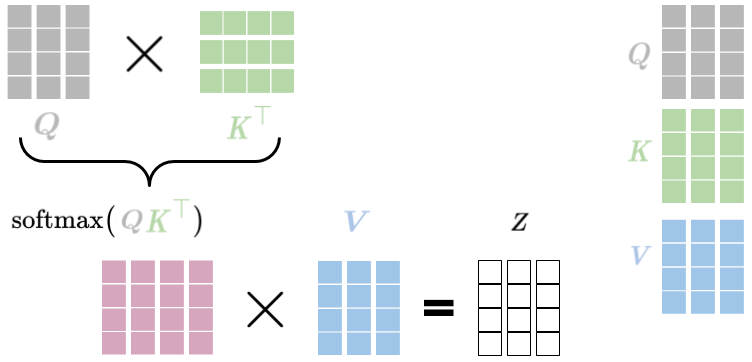</body></html>
< src="images/C4_W2_L3_dot-product-attention_S04_attention-math_stripped.png" width="500"/>
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>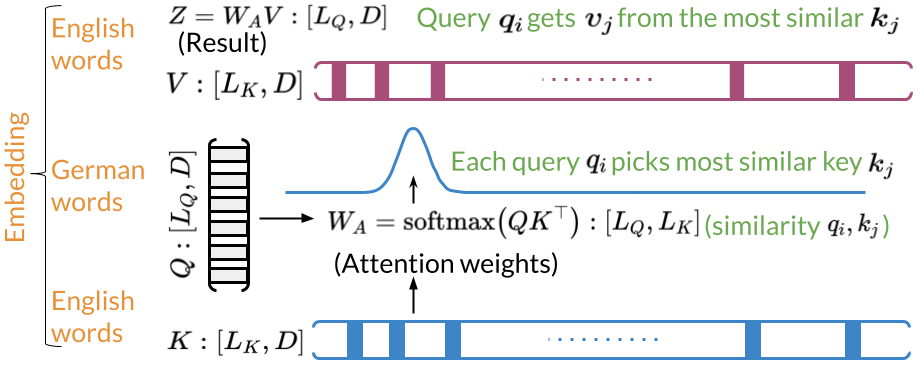</body></html>
With basic dot product attention, you capture the interactions between every word (embedding) in your query and every word in your key. If the queries and keys belong to the same sentences, this constitutes **bi-directional self-attention**. In some situations, however, it's more appropriate to consider only words which have come before the current one. Such cases, particularly when the queries and keys come from the same sentences, fall into the category of **causal attention**. 

< src="images/C4_W2_L4_causal-attention_S02_causal-attention_stripped.png" width="500"/>
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>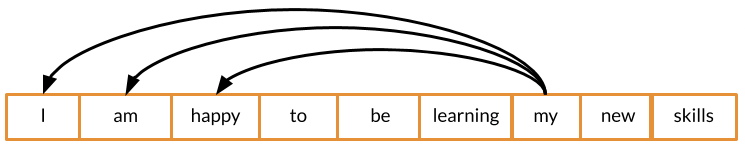</body></html>
For causal attention, we add a **mask** to the argument of our softmax function, as illustrated below: 

< src="images/C4_W2_L4_causal-attention_S03_causal-attention-math_stripped.png" width="500"/>
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>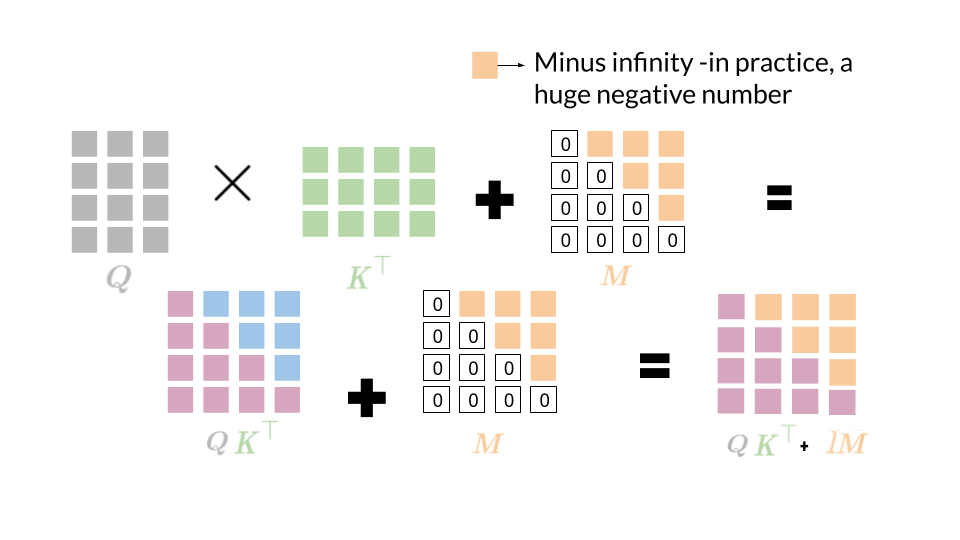</body></html>
<src="images/C4_W2_L4_causal-attention_S04_causal-attention-math-2_stripped.png" width="500"/>
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>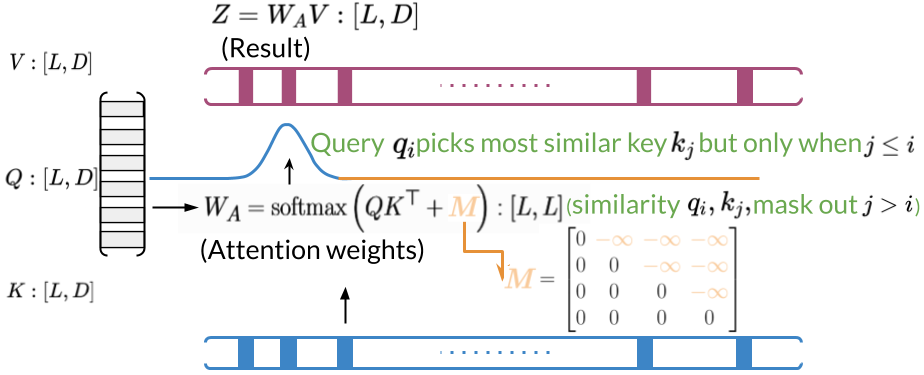</body></html>
Now let's see how to implement attention with NumPy. When you integrate attention into a transformer network defined with trax, you'll have to use `trax.fastmath.numpy` instead, since trax's arrays are based on JAX DeviceArrays. Fortunately, the function interfaces are often identical.

## Imports

In [1]:
import sys

import numpy as np
import scipy.special

import textwrap
wrapper = textwrap.TextWrapper(width=70)

# to print the entire np array
np.set_printoptions(threshold=sys.maxsize)

Here are some helper functions that will help you create tensors and display useful information:

* `create_tensor()` creates a numpy array from a list of lists.
* `display_tensor()` prints out the shape and the actual tensor.

In [2]:
def create_tensor(t):
    """Create tensor from list of lists"""
    return np.array(t)


def display_tensor(t, name):
    """Display shape and tensor"""
    print(f'{name} shape: {t.shape}\n')
    print(f'{t}\n')

Create some tensors and display their shapes. Feel free to experiment with your own tensors. Keep in mind, though, that the query, key, and value arrays must all have the same embedding dimensions (number of columns), and the mask array must have the same shape as `np.dot(query, key.T)`. 

In [3]:
q = create_tensor([[1, 0, 0], [0, 1, 0]])
display_tensor(q, 'query')
k = create_tensor([[1, 2, 3], [4, 5, 6]])
display_tensor(k, 'key')
v = create_tensor([[0, 1, 0], [1, 0, 1]])
display_tensor(v, 'value')
m = create_tensor([[0, 0], [-1e9, 0]])
display_tensor(m, 'mask')

query shape: (2, 3)

[[1 0 0]
 [0 1 0]]

key shape: (2, 3)

[[1 2 3]
 [4 5 6]]

value shape: (2, 3)

[[0 1 0]
 [1 0 1]]

mask shape: (2, 2)

[[ 0.e+00  0.e+00]
 [-1.e+09  0.e+00]]



## Dot product attention

Here we come to the crux of this lab, in which we compute 
$\textrm{softmax} \left(\frac{Q K^T}{\sqrt{d}} + M \right) V$, where the (optional, but default) scaling factor $\sqrt{d}$ is the square root of the embedding dimension.

In [4]:
def DotProductAttention(query, key, value, mask, scale=True):
    """Dot product self-attention.
    Args:
        query (numpy.ndarray): array of query representations with shape (L_q by d)
        key (numpy.ndarray): array of key representations with shape (L_k by d)
        value (numpy.ndarray): array of value representations with shape (L_k by d) where L_v = L_k
        mask (numpy.ndarray): attention-mask, gates attention with shape (L_q by L_k)
        scale (bool): whether to scale the dot product of the query and transposed key

    Returns:
        numpy.ndarray: Self-attention array for q, k, v arrays. (L_q by L_k)
    """

    assert query.shape[-1] == key.shape[-1] == value.shape[-1], "Embedding dimensions of q, k, v aren't all the same"

    # Save depth/dimension of the query embedding for scaling down the dot product
    if scale: 
        depth = query.shape[-1]
    else:
        depth = 1

    # Calculate scaled query key dot product according to formula above
    dots = np.matmul(query, np.swapaxes(key, -1, -2)) / np.sqrt(depth) 
    
    # Apply the mask
    if mask is not None:
        dots = np.where(mask, dots, np.full_like(dots, -1e9)) 
    
    # Softmax formula implementation
    # Use scipy.special.logsumexp of masked_qkT to avoid underflow by division by large numbers
    # Note: softmax = e^(dots - logaddexp(dots)) = E^dots / sumexp(dots)
    logsumexp = scipy.special.logsumexp(dots, axis=-1, keepdims=True)

    # Take exponential of dots minus logsumexp to get softmax
    # Use np.exp()
    dots = np.exp(dots - logsumexp)

    # Multiply dots by value to get self-attention
    # Use np.matmul()
    attention = np.matmul(dots, value)
    
    return attention

Now let's implement the *masked* dot product self-attention (at the heart of causal attention) as a special case of dot product attention

In [7]:
def dot_product_self_attention(q, k, v, scale=True):
    """ Masked dot product self attention.
    Args:
        q (numpy.ndarray): queries.
        k (numpy.ndarray): keys.
        v (numpy.ndarray): values.
    Returns:
        numpy.ndarray: masked dot product self attention tensor.
    """
    
    # Size of the penultimate dimension of the query
    mask_size = q.shape[-2]

    # Creates a matrix with ones below the diagonal and 0s above. It should have shape (1, mask_size, mask_size)
    # Use np.tril() - Lower triangle of an array and np.ones()
    mask = np.tril(np.ones((1, mask_size, mask_size), dtype=np.bool_), k=0)  
    print(mask)    
    return DotProductAttention(q, k, v, mask, scale=scale)

In [8]:
dot_product_self_attention(q, k, v)

[[[ True False]
  [ True  True]]]


array([[[0.        , 1.        , 0.        ],
        [0.84967455, 0.15032545, 0.84967455]]])